In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from os.path import join

main_dir = "/content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main"

In [6]:
s = '/'
model_dir = join(main_dir,"model")
data_dir = join(main_dir, "data")

print("model_dir", model_dir)
print("data_dir", data_dir)

model_dir /content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/model
data_dir /content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/data


In [7]:
cd /content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/

/content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main


In [30]:
import argparse
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch import FloatTensor
# import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms

from net.unet import U_Net
from net.attention_unet import AttU_Net
from dataset import FireDataset

def set_seed(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)

def get_dataset(img_dir, mask_dir, transform_mode, transform_types, mode):
    dataset_class = FireDataset(img_dir, mask_dir, transform_mode, transform_types, mode)
    return dataset_class

# +
def evaluate(args, model, test_dataloader):
    model.eval()
    criterion = nn.BCELoss()
    eval_losses = []
    sensitivities = []
    specificities = []
    ppvs = []
    npvs = []
    f1s = []

    
    for cutoff in np.linspace(0,1,11):
        temp_sens = [] #recall
        temp_spec = [] 
        temp_ppv = [] #precision
        temp_npv = []
        temp_f1s = []


        for step, (images, masks) in enumerate(test_dataloader):
        
          if args.cuda:
              images = images.cuda(args.device_id)
              masks = masks.cuda(args.device_id)
        
          with torch.no_grad():
              output_masks = model(images)
              output_masks = torch.sigmoid(output_masks)
              loss = criterion(output_masks, masks)
              eval_losses.append(loss.item())
            
              output_masks = output_masks.detach().cpu().numpy()
              output_masks = np.where(output_masks > cutoff, 1, 0)
              masks = masks.detach().cpu().numpy()
          
              #Scoring
              tp = ((output_masks == 1) & (masks == 1)).sum()
              tn = ((output_masks == 0) & (masks == 0)).sum()
              fp = ((output_masks == 1) & (masks == 0)).sum()
              fn = ((output_masks == 0) & (masks == 1)).sum()
            
              #print("tp = %d, tn = %d, fp = %d, fn = %d" \
                    #%(tp, tn, fp ,fn))
            
              sensitivity = tp / (tp + fn) #recall
              specificity = tn / (fp + tn)
              if (tp + fp) == 0:
                ppv = 1
              else:
                ppv = tp / (fp + tp) #precision
              npv = tn / (fn + tn)
              f1 = 2*tp/(2*tp + fp + fn)
              
              temp_sens.append(sensitivity)
              temp_spec.append(specificity)
              temp_ppv.append(ppv)
              temp_npv.append(npv)
              temp_f1s.append(f1)


        sensitivities.append(np.mean(temp_sens))
        specificities.append(np.mean(temp_spec))
        ppvs.append(np.mean(temp_ppv))
        npvs.append(np.mean(temp_npv))
        f1s.append(np.mean(temp_f1s))  
    
    auc = np.trapz(np.flip(ppvs), np.flip(sensitivities))

#     return np.mean(eval_losses)
    return np.mean(eval_losses), np.array(sensitivities), np.mean(specificities), np.mean(f1s), np.array(ppvs), np.mean(npvs), auc


# -

def train(args, train_dataloader, test_dataloader):

    epochs = args.epochs
    batch_size = args.batch_size
    learning_rate = args.lr
    log_interval = args.log_interval

    # Model
    if args.net == 'unet':
        model = U_Net(img_ch=1, output_ch=1)
    if args.net == 'attn_unet':
        model = AttU_Net(img_ch=1, output_ch=1)

    if args.cuda:
        model.cuda(args.device_id)

    # Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Loss criterion - BCE: binary cross entropy loss, as 2 classes in mask
    criterion = nn.BCELoss()


    # Begin training
    print("Model :", args.net)
    print("Cutoff :", args.cutoff)
    print("Train Dataloader size :",len(train_dataloader))
    print("Transform mode :",args.transform_mode)
    print("Batch size :", batch_size)
    print("Epochs :",epochs)
    print("Begin Training")
    model.train()
    model.zero_grad()

    best_eval_f1 = 0.5

    for epoch in range(epochs):
        epoch_losses = []
        for step, (images, masks) in enumerate(train_dataloader):
            model.train()

            if args.cuda:
                images = images.cuda(args.device_id)
                masks = masks.cuda(args.device_id)

            output_masks = model(images)
            output_masks = torch.sigmoid(output_masks)
            loss = criterion(output_masks, masks)
            # print(loss)

            loss.backward()
            optimizer.step()
            model.zero_grad()

            epoch_losses.append(loss.item())

        # Printing
        if epoch % log_interval == 0:
            current_epoch_loss = np.mean(epoch_losses)
            eval_loss, eval_sens, eval_spec, eval_f1, eval_ppv, eval_npv, eval_auc = evaluate(args, model, test_dataloader)
            rounded_sens = np.around(eval_sens, decimals = 3)
            rounded_ppv = np.around(eval_ppv, decimals = 3)
            print("Epoch %d, Loss %.3f, Eval: Loss %.3f, AUC %.3f" \
                  %(epoch, current_epoch_loss, eval_loss, eval_auc))
            print(f"PPVs: {rounded_ppv}, Sensitivities: {rounded_sens}")
            #print("Epoch %d, Loss %.3f, Eval: Loss %.3f, Sens %.3f, Spec %.3f, F1 %.3f, PPV %.3f, NPV %.3f, AUC %.3f" \
                  #%(epoch, current_epoch_loss, eval_loss, eval_sens, eval_spec, eval_f1, eval_ppv, eval_npv, eval_auc))

            #Save the model with minimun evaluation sensitivity :
            if epoch > 10 and eval_auc > 0.6:
                # Save the model
                print("Saving epoch %d model"%(epoch))
                torch.save(model.state_dict(), 'trained_model_'+str(epoch)+'_'+str(args.net))
                #best_auc = eval_auc


In [27]:
class Args:
  def __init__(self):
    self.train_img_dir = join(data_dir, "train_images")
    self.train_mask_dir = join(data_dir, "train_masks")
    self.test_img_dir = join(data_dir, "test_images")
    self.test_mask_dir = join(data_dir, "test_masks")

    self.net = 'attn_unet'
    self.epochs = 100
    self.batch_size = 8
    self.cutoff = 0.30
    self.lr = 0.001
    self.log_interval = 1
    self.transform_mode = 'basic'
    self.device_id = 0
    self.seed = 10
    self.transform_types = []#'crop_hflip_vflip'


In [28]:
args = Args()
print(vars(args))
print(args.batch_size)

{'train_img_dir': '/content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/data/train_images', 'train_mask_dir': '/content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/data/train_masks', 'test_img_dir': '/content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/data/test_images', 'test_mask_dir': '/content/drive/MyDrive/Fire_Prediction/Fire_Mapping_Project-main/data/test_masks', 'net': 'unet', 'epochs': 100, 'batch_size': 8, 'cutoff': 0.3, 'lr': 0.001, 'log_interval': 1, 'transform_mode': 'basic', 'device_id': 0, 'seed': 10, 'transform_types': []}
8


In [29]:
# Set CUDA
args.cuda = True if torch.cuda.is_available() else False
print("Cuda",args.cuda)

# Set seed
set_seed(args)

# Get datasets

train_dataset = get_dataset(args.train_img_dir, args.train_mask_dir, args.transform_mode, transform_types=args.transform_types, mode="train")
test_dataset = get_dataset(args.test_img_dir, args.test_mask_dir, "basic", transform_types=[], mode="test")

train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)

train(args, train_dataloader, test_dataloader)

Cuda True
Dataset mode train Transform basic Transform types []
Dataset mode test Transform basic Transform types []
Model : unet
Cutoff : 0.3
Train Dataloader size : 4
Transform mode : basic
Batch size : 8
Epochs : 100
Begin Training


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in long_scalars


KeyboardInterrupt: ignored

In [ ]:
dsfasdfasfdssdfasdffdd

In [ ]:
len(train_dataset)

30

In [13]:
eval_sens

NameError: ignored

# New Section

In [ ]:
!python train.py --transform_types '[]' 

Cuda True
Dataset mode train Transform basic Transform types ['[]']
Dataset mode test Transform basic Transform types []
Model : unet
Cutoff : 0.3
Train Dataloader size : 4
Transform mode : basic
Transform types: ['[]']
Batch size : 8
Epochs : 100
Begin Training
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
train.py:69: RuntimeWarning: invalid value encountered in long_scalars
  npv = tn / (fn + tn)
Epoch 0, Loss 0.580, Eval: Loss 0.630, Sens 1.000, Spec 0.000, F1 0.125, PPV 0.073, NPV nan
Epoch 1, Loss 0.404, Eval: Loss 0.594, Sens 1.000, Spec 0.000, F1 0.125, PPV 0.073, NPV nan
Epoch 2, Loss 0.364, Eval: Loss 0.557, Sens 1.000, Spec

In [22]:
!python eval.py --trained_model trained_model_69_unet --net unet --test_img_dir data/train_images --test_mask_dir data/train_masks

Cuda True
Dataset mode test Transform basic Transform types []
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
eval.py:125: RuntimeWarning: invalid value encountered in long_scalars
  npv = tnsum / (fnsum + tnsum)
cutoffs used:  [0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81

In [24]:
#save output
recall_85 = [1.0, 1.0, 0.9939652870493992, 0.9875300400534045, 0.9837116154873164, 0.9806675567423231, 0.977690253671562, 0.9749666221628839, 0.9724432576769025, 0.9701068090787717, 0.9676769025367156, 0.9648197596795728, 0.9626702269692924, 0.9607877169559412, 0.9590387182910547, 0.9573297730307077, 0.955607476635514, 0.9540587449933244, 0.9525100133511348, 0.9509612817089452, 0.9495460614152202, 0.9481842456608812, 0.9467423230974633, 0.9453137516688919, 0.9437783711615487, 0.9423230974632844, 0.9407877169559412, 0.9393991989319093, 0.9380774365821095, 0.9367289719626168, 0.9352469959946595, 0.9338985313751669, 0.9322963951935914, 0.9309212283044058, 0.9295193591455274, 0.9279572763684913, 0.9259679572763685, 0.9242723631508678, 0.92260347129506, 0.9206275033377838, 0.9185847797062751, 0.9167556742323097, 0.9148331108144192, 0.912630173564753, 0.9105874499332444, 0.9086381842456609, 0.9067423230974633, 0.904712950600801, 0.9032176234979973, 0.9010413885180241, 0.8990520694259012, 0.8971161548731642, 0.895260347129506, 0.8931508678237651, 0.8909479305740988, 0.8887449933244326, 0.886475300400534, 0.8841388518024033, 0.8817222963951936, 0.8789452603471295, 0.8765020026702269, 0.8738985313751669, 0.8709345794392523, 0.8683311081441922, 0.865113484646195, 0.8623898531375167, 0.859452603471295, 0.8559679572763685, 0.8525767690253672, 0.8490921228304406, 0.845634178905207, 0.8425901201602136, 0.8392656875834446, 0.8358611481975968, 0.8327236315086782, 0.8289586114819759, 0.8253137516688919, 0.821388518024032, 0.8178104138851803, 0.8134846461949266, 0.8091188251001336, 0.8046595460614152, 0.7997463284379173, 0.7945927903871829, 0.7888918558077437, 0.7836315086782376, 0.7769025367156208, 0.7703871829105474, 0.7634846461949266, 0.7556608811748998, 0.7473831775700934, 0.7378237650200267, 0.7272229639519359, 0.7147530040053405, 0.700694259012016, 0.6830040053404539, 0.661588785046729, 0.6346061415220293, 0.5952469959946596, 0.5227369826435248, 0.0]

prec_85 = [0.03868120336242428, 0.043130502882085, 0.14503827204027284, 0.175069941821659, 0.18779342723004694, 0.19648661011644425, 0.2032134978007798, 0.20853799232386, 0.21310098861585003, 0.2171344386138969, 0.22069467408415622, 0.22368286650839295, 0.22653626107091354, 0.22919539717371434, 0.23162945478466124, 0.23390103634886825, 0.23595479689591287, 0.23796821717817562, 0.23986484214773224, 0.24161781866536405, 0.24338669605152388, 0.24512808830534097, 0.24676798012242526, 0.24847519248720845, 0.25020263550032384, 0.25184386964635525, 0.25348216469775675, 0.2551659860886468, 0.25678303072829867, 0.25842845619191795, 0.26004350763610984, 0.26157470598133986, 0.2631342934876815, 0.2646610034389305, 0.2662859721860992, 0.2679031903699164, 0.2695187872334638, 0.2713376395334253, 0.27321538005337553, 0.2750981424741478, 0.2770230550567317, 0.2791941123851346, 0.2815090835887365, 0.2837090193702088, 0.2860540123392066, 0.2884883577989818, 0.29094375187422356, 0.2932269985373917, 0.29549018323178056, 0.2975084198832678, 0.2995187346546632, 0.3015996983733707, 0.3037213852829539, 0.30578130856500313, 0.30780442804428043, 0.30988492263002065, 0.3121054437597244, 0.3141326983193317, 0.3163019478808953, 0.31837526235866487, 0.32058481702493385, 0.32264663403477123, 0.32460365641265515, 0.3267354587197444, 0.32872021469264756, 0.33091184803045126, 0.3330108739511448, 0.3350316940233381, 0.3371897160780007, 0.33938853815899717, 0.34168051269878946, 0.34419005442904044, 0.34679252361196927, 0.3492371628594539, 0.35189542041152544, 0.354522822524467, 0.3572373857916423, 0.3599103763374811, 0.36286194967063173, 0.36575702640077795, 0.3688243241598403, 0.37193902740064183, 0.3752584165486825, 0.3788182576206025, 0.3825852736266867, 0.3864981792560302, 0.39043471842940436, 0.3947379222591635, 0.39973297543653624, 0.4050713539355596, 0.4114439013634192, 0.41865591927333884, 0.4265020241012912, 0.43588177821201757, 0.44669333560303004, 0.46018566827986973, 0.4779463536492443, 0.5016569920844327, 0.5350486636984411, 0.588245015700356, 1.0]

#f2 = 5*(recall_85*prec_85)/((4*prec_85)+recall_85)

cutoffs_used = np.linspace(0,1,101)

np.trapz(recall_85, prec_85)

0.5666738402645227

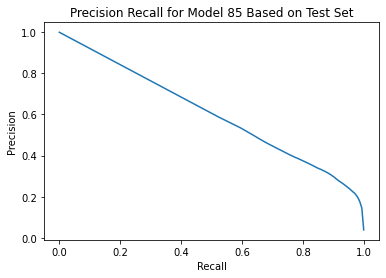

In [25]:
#Plotting graph
import matplotlib
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes()

plt.title("Precision Recall for Model 85 Based on Test Set")
plt.xlabel("Recall")
plt.ylabel("Precision")
ax.plot(recall_85, prec_85)